In [405]:
import numpy as np
import pandas as pd
import seaborn as sns
import random
from sklearn import model_selection
from sklearn.metrics import f1_score, recall_score, precision_score, precision_recall_curve
from sklearn.preprocessing import StandardScaler
import warnings
warnings.simplefilter('ignore')
from matplotlib import pyplot as plt
%matplotlib inline

In [406]:
from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint

In [407]:
# input
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'
PREP_DATASET_PATH ='course_project_train_prep.csv'
PREP_DATASET_TRARGET_PATH = 'course_project_train_prep_target.csv'


In [408]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [409]:
df_train.shape

(7500, 17)

In [410]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [411]:
df_train['ID'] = df_train.index.tolist()

In [412]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_train.columns.drop(TARGET_NAME).tolist()


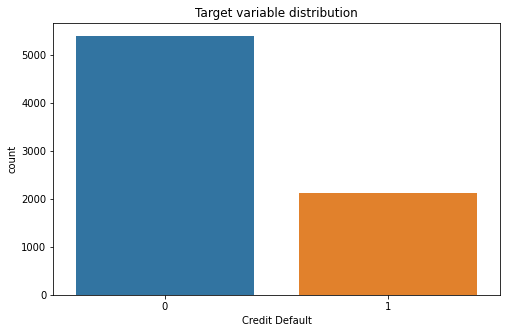

In [413]:
plt.figure(figsize=(8, 5))

sns.countplot(x=TARGET_NAME, data=df_train)

plt.title('Target variable distribution')
plt.show()

In [414]:
df_train.loc[df_train['Years in current job'].isnull(), 'Years in current job'] = 'NaN'

In [415]:
pd.crosstab(df_train['Years in current job'], df_train['Credit Default'])

Credit Default,0,1
Years in current job,,
1 year,362,142
10+ years,1688,644
2 years,512,193
3 years,450,170
4 years,338,131
5 years,371,145
6 years,302,124
7 years,285,111
8 years,247,92


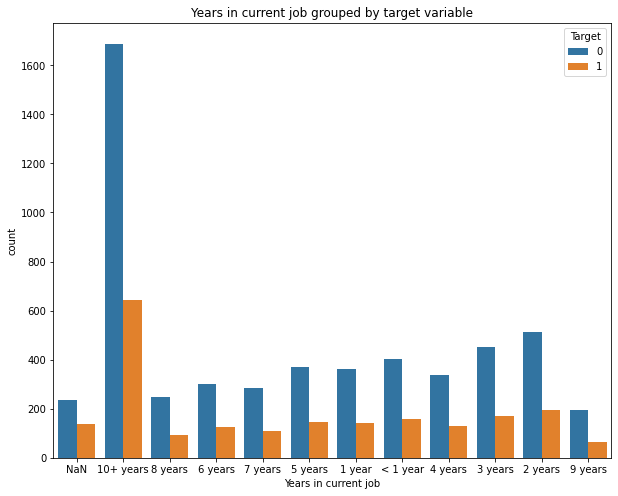

In [416]:
plt.figure(figsize=(10, 8))

sns.countplot(x="Years in current job", hue=TARGET_NAME, data=df_train)
plt.title('Years in current job grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

Вероятность дефолта в зависимости от числа лет работы

In [417]:
df_train[['Years in current job', 'Credit Default']].groupby('Years in current job').mean()

,Credit Default
Years in current job,
1 year,0.281746
10+ years,0.276158
2 years,0.273759
3 years,0.274194
4 years,0.279318
5 years,0.281008
6 years,0.291080
7 years,0.280303
8 years,0.271386


**Наблюдение**

Изучив получившейся таблицы график, видно, что все значения кроме Nan  признака Years in current job имеют схожие доли в разрезе целевой переменной. Если это действительно так, то можно будет, например, объединить их в одну категорию.

**Гипотеза** 

* Нулевая гипотеза: ожидаемые и наблюдаемые частоты согласованы
* Альтернативная гипотеза: отклонения в частотах выходят за рамки случайных колебаний, расхождения статистически значимы
* Критерий: Хи-квадрат Пирсона
* Уровень значимости $\normalsize \alpha$: 0.05
* Критическая область: двухсторонняя


In [418]:
names=df_train['Years in current job'].unique()[1:]

In [419]:
years_and_target_s = df_train.loc[df_train['Years in current job'].isin(names), ['ID','Years in current job', 'Credit Default']].sample(1000)

In [420]:
table = years_and_target_s.pivot_table(values='ID', index='Years in current job', columns='Credit Default', aggfunc='count')
table

Credit Default,0,1
Years in current job,,
1 year,57,13
10+ years,231,100
2 years,59,30
3 years,71,26
4 years,44,14
5 years,47,16
6 years,35,25
7 years,42,19
8 years,37,11


In [421]:
chi2, p, dof, expected = chi2_contingency(table, correction=False)
p

0.2565170401347529

P-value получилось больше выбранного уровня значимости, соответственно у нас нет оснований для отвержения нулевой гипотезы и можно допустить, что все непустые категории признака Years in current job одинаково влияют на целевую переменную и их можно объединить в одну категорию, выделив NaN в качестве отдельного признака (условно приняв NaN = is_employed=0, остальные is_employed=1). 

In [422]:
df_train.loc[df_train['Years in current job']!='NaN', 'Years in current job'] = 1

In [423]:
df_train.loc[df_train['Years in current job']=='NaN', 'Years in current job'] = 0

Изучим признак Home Ownership

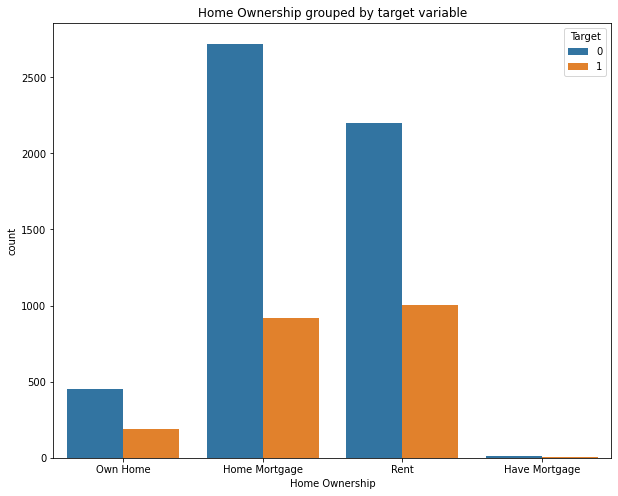

In [424]:
plt.figure(figsize=(10, 8))

sns.countplot(x="Home Ownership", hue=TARGET_NAME, data=df_train)
plt.title('Home Ownership grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

Зависимость дефолта от владения недвижимостью Home Ownership

In [425]:
df_train[['Home Ownership', 'Credit Default']].groupby('Home Ownership').mean()

,Credit Default
Home Ownership,
Have Mortgage,0.166667
Home Mortgage,0.251856
Own Home,0.296754
Rent,0.313046


Проверим гипотезу о том, является ли статистически значимой различие в распределении целевой переменной в зависимости от параметра Home Ownership

**Гипотеза** 

* Нулевая гипотеза: ожидаемые и наблюдаемые частоты согласованы
* Альтернативная гипотеза: отклонения в частотах выходят за рамки случайных колебаний, расхождения статистически значимы
* Критерий: Хи-квадрат Пирсона
* Уровень значимости $\normalsize \alpha$: 0.05
* Критическая область: двухсторонняя

In [426]:
#names=df_train['Home Ownership'].unique()
names=['Have Mortgage',
       'Home Mortgage',
       'Own Home', 
       'Rent']
homeownership_and_target_s = df_train.loc[df_train['Home Ownership'].isin(names), ['ID','Home Ownership', 'Credit Default']].sample(1000)

In [427]:
table = homeownership_and_target_s.pivot_table(values='ID', index='Home Ownership', columns='Credit Default', aggfunc='count', fill_value=0)
table

Credit Default,0,1
Home Ownership,,
Home Mortgage,373,120
Own Home,52,28
Rent,302,125


In [428]:
chi2, p, dof, expected = chi2_contingency(table[1:], correction=False)
p

0.3058724762822042

P-value получилось меньше выбранного уровня значимости, соответственно различия в значении целевой переменной в зависимости от признака Home Ownership статистически значимы

Изучим признак Purpose

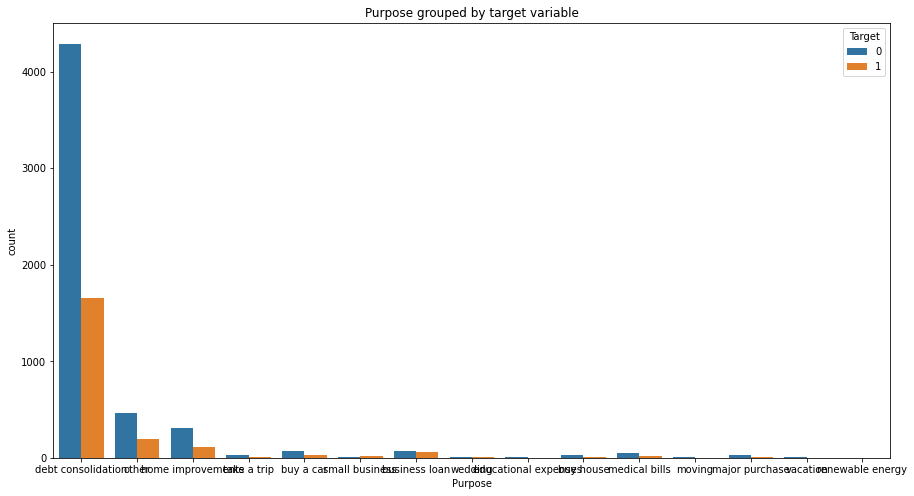

In [429]:
plt.figure(figsize=(15, 8))

sns.countplot(x="Purpose", hue=TARGET_NAME, data=df_train)
plt.title('Purpose grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

Зависимость вероятности дефолта от цели кредита

In [430]:
df=df_train[['Purpose', 'Credit Default']].groupby('Purpose').mean()
df=df.sort_values(by='Credit Default')
df

,Credit Default
Purpose,
educational expenses,0.100000
moving,0.181818
major purchase,0.225000
buy a car,0.250000
vacation,0.250000
home improvements,0.262136
buy house,0.264706
wedding,0.266667
take a trip,0.270270


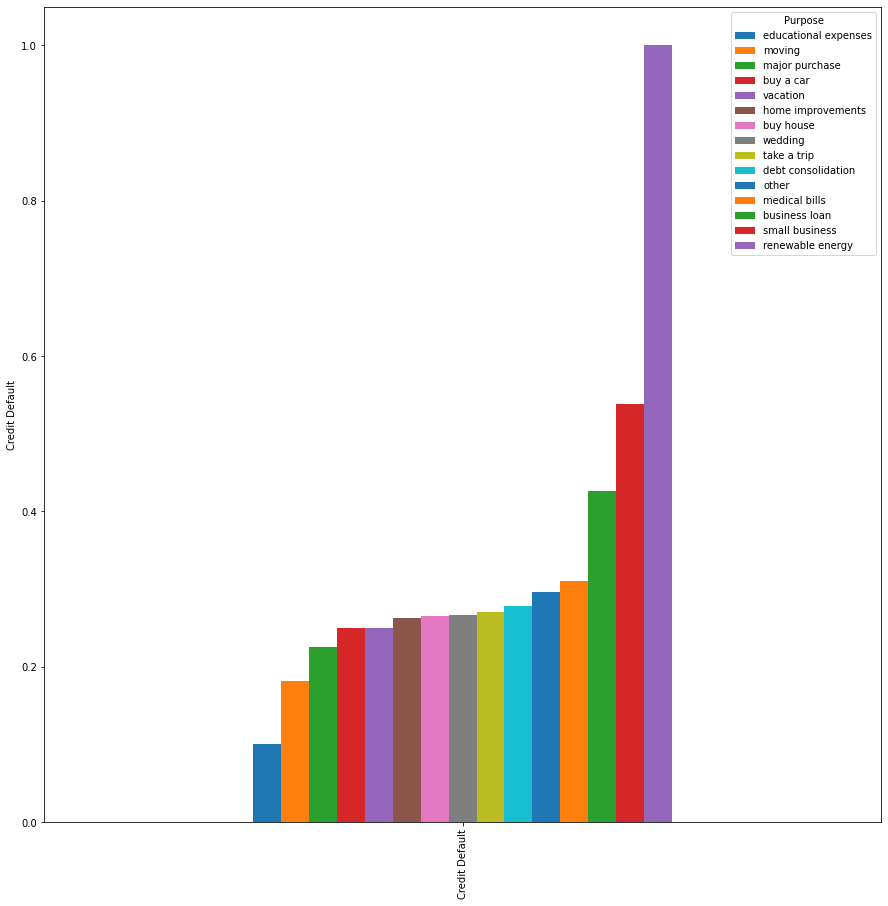

In [431]:
ax = df.T.plot(kind='bar', figsize=(15,15))
ylab = ax.set_ylabel('Credit Default')

Наблюдение

Изучив  график, видно, что все в группц other ьожно попробовать добавить ряд признаков вероятность дефолта по которым примерно 0,25.

Гипотеза

Нулевая гипотеза: ожидаемые и наблюдаемые частоты согласованы
Альтернативная гипотеза: отклонения в частотах выходят за рамки случайных колебаний, расхождения статистически значимы
Критерий: Хи-квадрат Пирсона
Уровень значимости  𝛼 : 0.05
Критическая область: двухсторонняя

In [432]:
names = ['debt consolidation', 
         'other', 
         'home improvements', 
         'take a trip',         
         'buy a car', 
         #'small business', 
         #'business loan', 
         'wedding',
         #'educational expenses', 
         'buy house', 
         'medical bills', 
         #'moving',
         'major purchase', 
         'vacation', 
         #'renewable energy'
         ]

In [433]:
purpose_target_s = df_train.loc[df_train['Purpose'].isin(names), ['ID','Purpose', 'Credit Default']].sample(1000)

In [434]:
table = purpose_target_s.pivot_table(values='ID', index='Purpose', columns='Credit Default', aggfunc='count', fill_value=0)
table

Credit Default,0,1
Purpose,,
buy a car,10,5
buy house,3,0
debt consolidation,587,234
home improvements,38,9
major purchase,2,1
medical bills,6,5
other,61,26
take a trip,5,0
vacation,3,1


In [435]:
chi2, p, dof, expected = chi2_contingency(table, correction=False)
p

0.6272524615118975

P-value получилось больше выбранного уровня значимости, соответственно можо объедиить выбраннные признакии в один признак

In [436]:
df_train.loc[df_train['Purpose'].isin(names), 'Purpose'] = 'other'

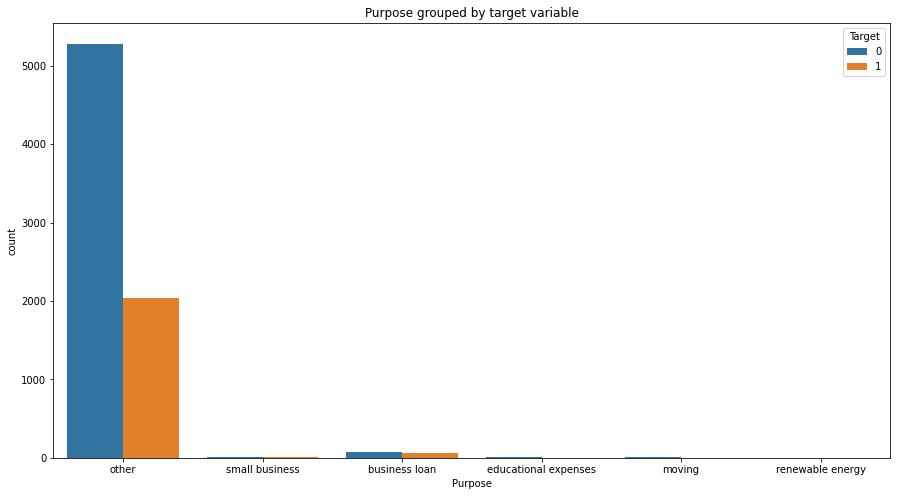

In [437]:
plt.figure(figsize=(15, 8))

sns.countplot(x="Purpose", hue=TARGET_NAME, data=df_train)
plt.title('Purpose grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

In [438]:
df=df_train[['Purpose', 'Credit Default']].groupby('Purpose').mean()
df=df.sort_values(by='Credit Default')
df

,Credit Default
Purpose,
educational expenses,0.100000
moving,0.181818
other,0.278476
business loan,0.426357
small business,0.538462
renewable energy,1.000000


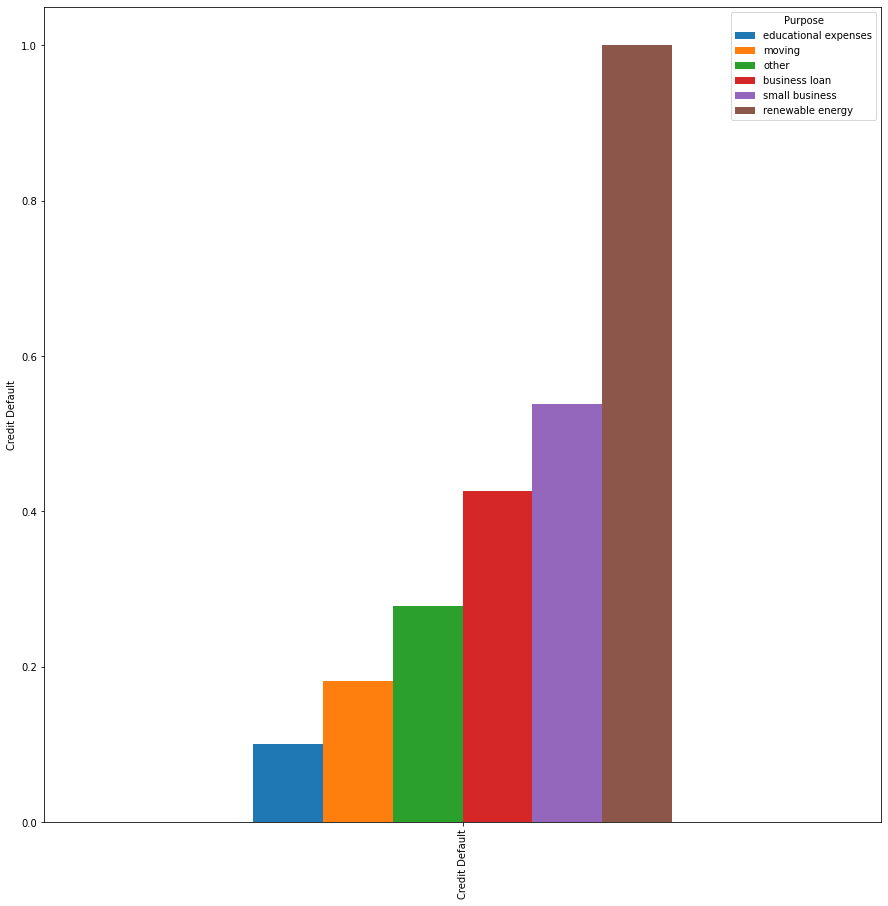

In [439]:
ax = df.T.plot(kind='bar', figsize=(15,15))
ylab = ax.set_ylabel('Credit Default')

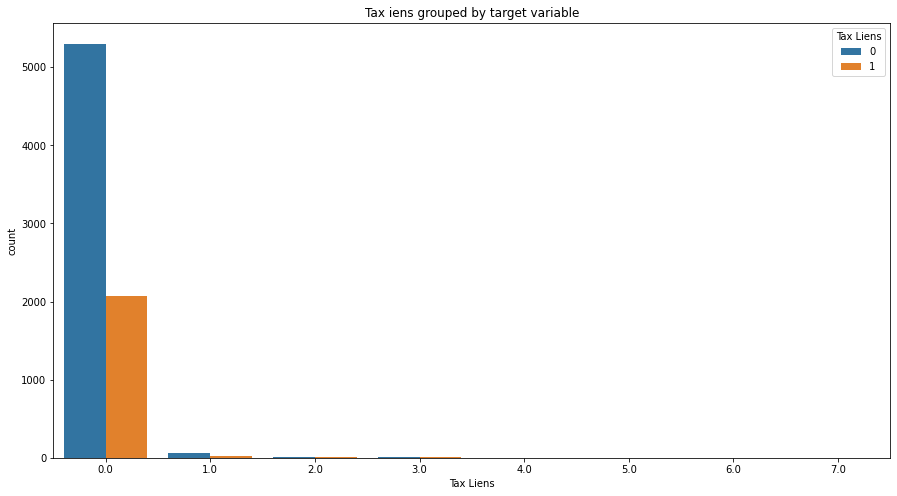

In [476]:
plt.figure(figsize=(15, 8))

sns.countplot(x="Tax Liens", hue=TARGET_NAME, data=df_train)
plt.title('Tax iens grouped by target variable')
plt.legend(title='Tax Liens', loc='upper right')

plt.show()

In [472]:
df=df_train[['Tax Liens', 'Credit Default']].groupby('Tax Liens').mean()
df=df.sort_values(by='Credit Default')
df

,Credit Default
Tax Liens,
6.0,0.000000
7.0,0.000000
0.0,0.280342
1.0,0.289157
2.0,0.500000
3.0,0.500000
4.0,0.500000
5.0,0.500000


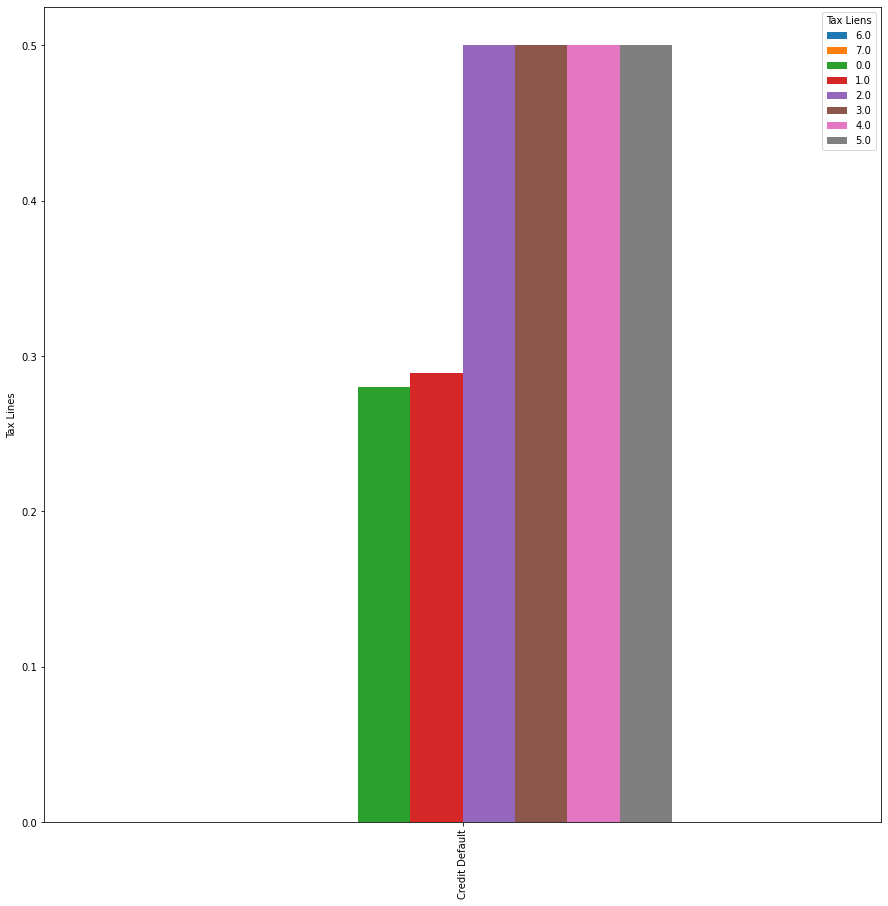

In [473]:
ax = df.T.plot(kind='bar', figsize=(15,15))
ylab = ax.set_ylabel('Tax Lines')

In [440]:
#df_train.loc[df_train['Months since last delinquent'].isnull(), 'Months since last delinquent'] = 'NaN'

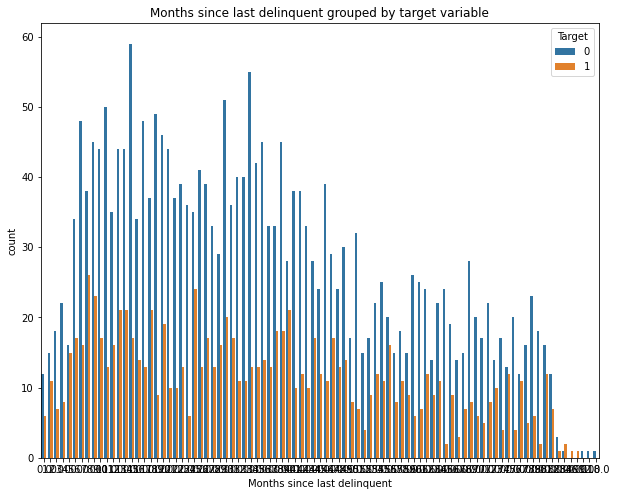

In [441]:
plt.figure(figsize=(10, 8))

sns.countplot(x="Months since last delinquent", hue=TARGET_NAME, data=df_train)
plt.title('Months since last delinquent grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

In [442]:
table = pd.pivot_table (df_train, values='Credit Default', index='Months since last delinquent',  aggfunc='mean' )

Зависимость вероятности кредитного дефолта от количества месяцев delinquent

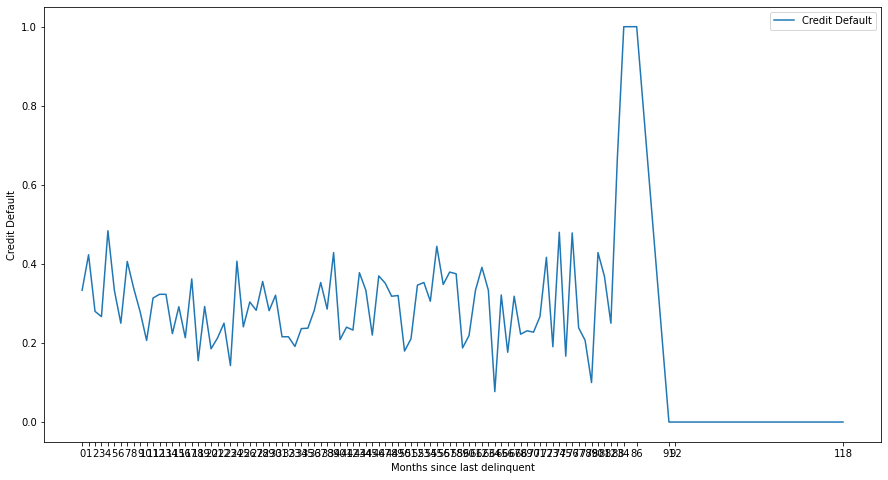

In [443]:
ax = table.plot(xticks=table.index, figsize=(15,8))
ylab = ax.set_ylabel('Credit Default')


Вывод. Пока никакой конкретики по этому признаку не сложилось. Склоняюсь к тому, чтобы его удалить. 

Распределение значение признака  Number of Open Accounts в тренировочной и тестовой выборке  

<AxesSubplot:xlabel='Number of Open Accounts'>

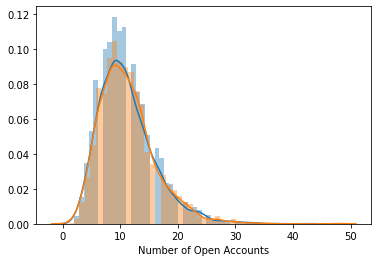

In [444]:
sns.distplot(df_train['Number of Open Accounts'])
sns.distplot(df_test['Number of Open Accounts'])

Вывод - тренировочная и тестовая выборки имеют одинаковое распределение и принадлежат одной генеральной совокупности

Распределение значений признака Number of Open Accounts в тренировочной и тестовой выборках

<AxesSubplot:xlabel='Number of Open Accounts'>

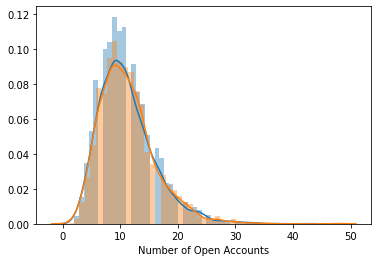

In [445]:
sns.distplot(df_train['Number of Open Accounts'])
sns.distplot(df_test['Number of Open Accounts'])

Вывод - тренировочная и тестовая выборки имеют одинаковое распределение и принадлежат одной генеральной совокупности

Исследование признака Credit Score

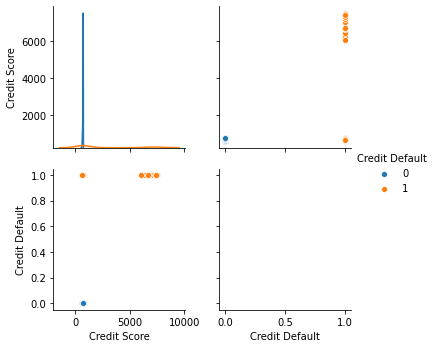

In [446]:
sns.pairplot(df_train.loc[:, ['Credit Score', 'Credit Default']], hue='Credit Default')

Вывод: Видно, что значения признака имеют 2 разных распределения. При для значения целевой переменной  Credut Default =1, значения признака достаточно плотно сгруппированы около середнего

Распределение значений признака в случае, когда Credit Default = 1

<AxesSubplot:xlabel='Credit Score'>

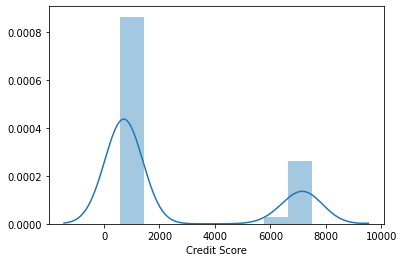

In [447]:
df_defaul1=df_train[df_train['Credit Default']==1]
df_defaul0=df_train[df_train['Credit Default']==0]
sns.distplot(df_defaul1[pd.notnull(df_defaul1['Credit Score'])]['Credit Score'])

Два пика распределения значения признака может видетельствовать об ошибке ввода данных 

Посмотрим распределения для признака, при котором целевая переменная =0

<AxesSubplot:xlabel='Credit Score'>

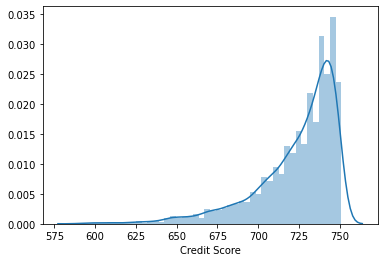

In [448]:
sns.distplot(df_defaul0[pd.notnull(df_defaul0['Credit Score'])]['Credit Score'])

Вывод: Все значения, для которых целевая переменная =0 меньше 750

In [449]:
df_train.loc[df_train['Credit Score']>4000, 'Credit Score'] = df_train['Credit Score']/10

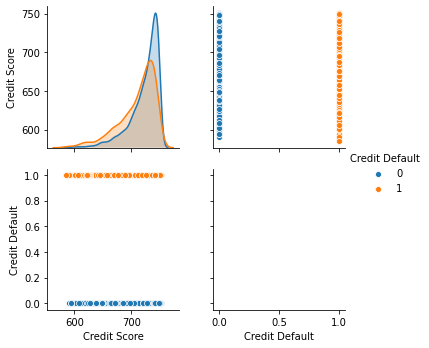

In [450]:
sns.pairplot(df_train.loc[:, ['Credit Score', 'Credit Default']], hue='Credit Default')

In [456]:
df_train1=df_train.loc[df_train['Credit Score'].notnull()]

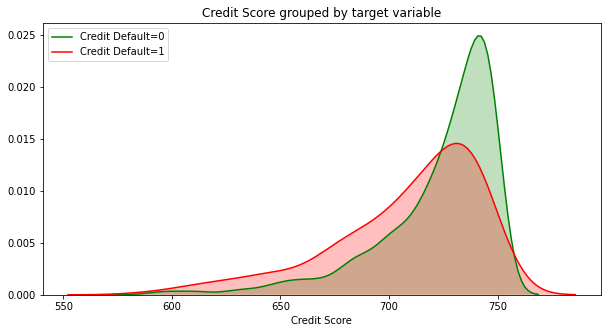

In [457]:
credit_score_with_target_s = df_train1[['Credit Score', TARGET_NAME]].sample(1000)
credit_score_s = credit_score_with_target_s['Credit Score']
credit_score_target_0 = credit_score_s[credit_score_with_target_s[TARGET_NAME] == 0]
credit_score_target_1 = credit_score_s[credit_score_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(credit_score_target_0, shade=True, label='Credit Default=0', color='g')
sns.kdeplot(credit_score_target_1, shade=True, label='Credit Default=1', color='r')

plt.xlabel('Credit Score')
plt.title('Credit Score grouped by target variable')
plt.show()

**Наблюдение**

Похоже что две группы, полученные в результате разбиения признака "Credit Score" по целевой переменной, имеют различные распределения, что может помочь при построение модели, т.к. это будет означать, что между признаком "Credit Score" и целевой переменной, возможно, существует некоторая функциональная зависимость.

**Гипотеза** 
* Нулевая гипотеза: средние значения в двух независимых выборках равны
* Альтернативная гипотеза: средние значения в двух независимых выборках различаются
* Критерий: критерий Стьюдента (t-тест) и его аналоги
* Уровень значимости $\normalsize \alpha$: 0.05
* Критическая область: двухсторонняя

Что бы проверить данную гипотезу сравним две выборки из рассматриваемых групп на предмет равенства средних значений.
Если вероятность того, что мат. ожидания в исходных группах равны, при данных выборках, буде менее 5%, то можно будет говорить о том, что скорее всего выборки имеют различные распределения.

Прверка распределения на нормальность

In [458]:
shapiro(credit_score_s)

(0.8365654349327087, 8.375368097348898e-31)

По полученному значению p-value, которое сильно меньше 0.05, можем заключить, что гипотеза о "нормальности" отвергается.

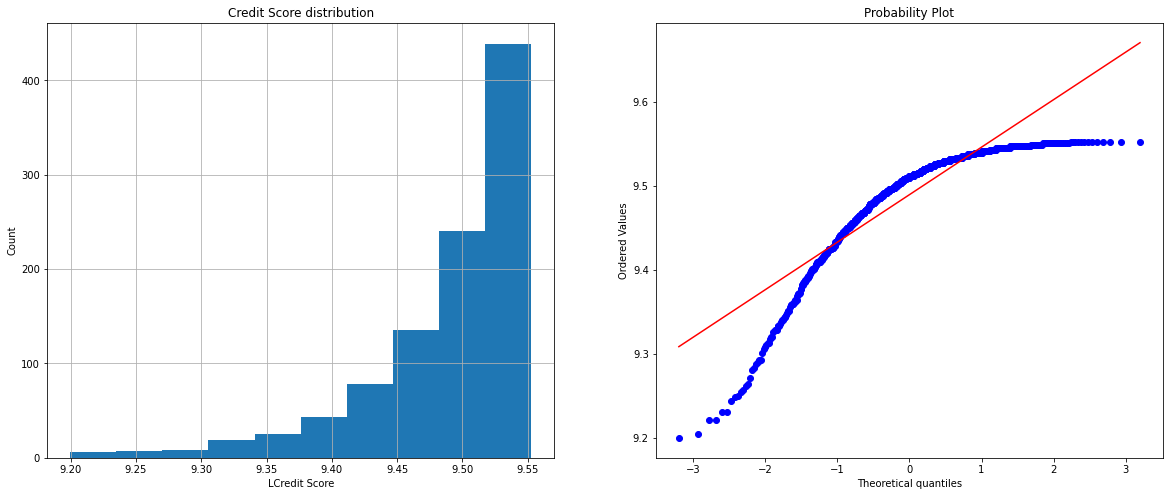

In [460]:
credit_score_log=np.log(credit_score_s)/np.log(2)


plt.figure(figsize=(20, 8))

ax1 = plt.subplot(121)
ax1.set_xlabel('LCredit Score')
ax1.set_ylabel('Count')
ax1.set_title('Credit Score distribution')
credit_score_log.hist()

plt.subplot(122)
probplot(credit_score_log, dist='norm', plot=plt)

plt.show()

При логарифмировании также не получается нормального распределения. Воспользуемся непараметрическими критериями

Оценим эквивалентность мат. ожадиний, в исследуемых группах, с помощью критерия Манна-Уитни для проверки гипотезы о равенстве мат ожиданий

In [461]:
mannwhitneyu(credit_score_target_0, credit_score_target_1)

MannwhitneyuResult(statistic=65375.0, pvalue=7.862234613651393e-13)

Согласно значению p-value, гипотеза о равности мат. ожиданий отвергается, но стоит ради дополнительной проверки обратиться к доверительным интервалам.

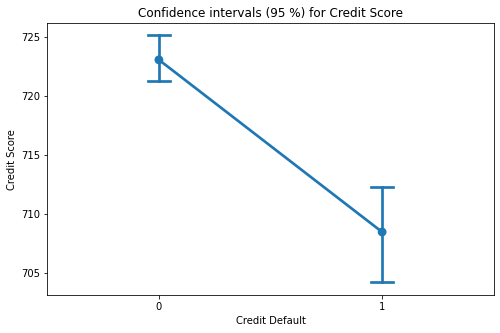

In [463]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Credit Score', data=credit_score_with_target_s, capsize=.1)

plt.title('Confidence intervals (95 %) for Credit Score')
plt.show()

Доверительные интервалы не перекрываются, значит можно использовать Credit Score в качестве хорошего признака

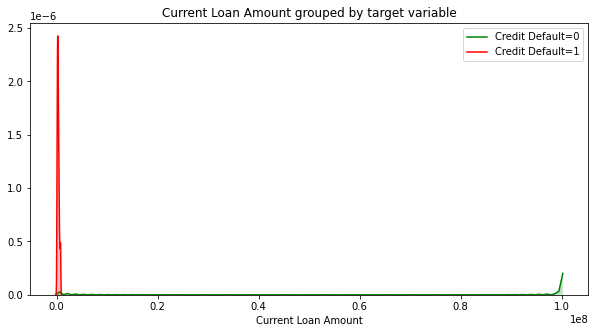

In [467]:
current_loan_with_target_s = df_train[['Current Loan Amount', TARGET_NAME]].sample(1000)
current_loan_s = current_loan_with_target_s['Current Loan Amount']
current_loan_target_0 = current_loan_s[current_loan_with_target_s[TARGET_NAME] == 0]
current_loan_target_1 = current_loan_s[current_loan_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(current_loan_target_0, shade=True, label='Credit Default=0', color='g')
sns.kdeplot(current_loan_target_1, shade=True, label='Credit Default=1', color='r')

plt.xlabel('Current Loan Amount')
plt.title('Current Loan Amount grouped by target variable')
plt.show()

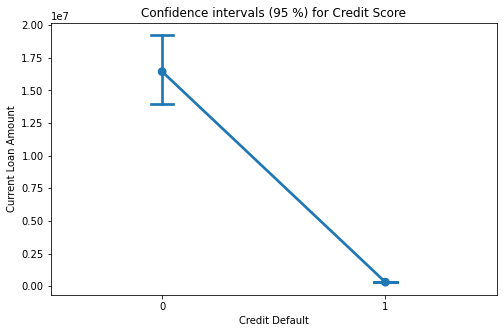

In [468]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Current Loan Amount', data=current_loan_with_target_s, capsize=.1)

plt.title('Confidence intervals (95 %) for Credit Score')
plt.show()

In [469]:
df_train1=df_train.loc[df_train['Annual Income'].notnull()]

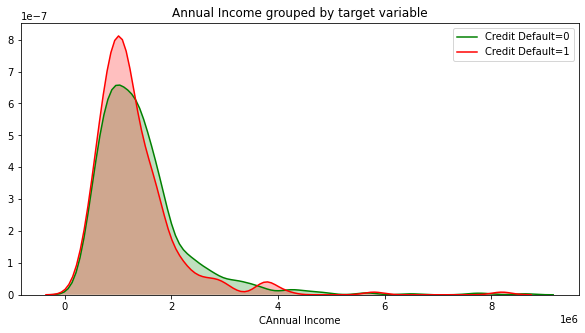

In [470]:
income_with_target_s = df_train1[['Annual Income', TARGET_NAME]].sample(1000)
income_s = income_with_target_s['Annual Income']
income_target_0 = income_s[income_with_target_s[TARGET_NAME] == 0]
income_target_1 = income_s[income_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(income_target_0, shade=True, label='Credit Default=0', color='g')
sns.kdeplot(income_target_1, shade=True, label='Credit Default=1', color='r')

plt.xlabel('Annual Income')
plt.title('Annual Income grouped by target variable')
plt.show()

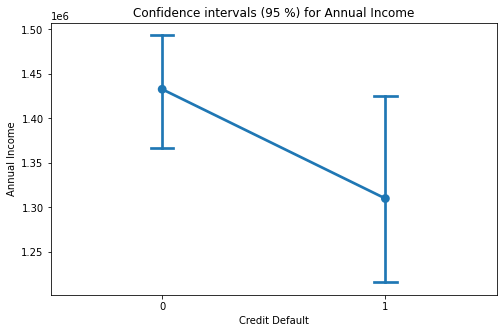

In [471]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Annual Income', data=income_with_target_s, capsize=.1)

plt.title('Confidence intervals (95 %) for Annual Income')
plt.show()

Доверительные интервалы по значению мат. ожидания празнака в зависомости от значения целевой переменной перекрываются, признак не очень хороший

In [401]:
df_train['ID'] = df_train.index.tolist()

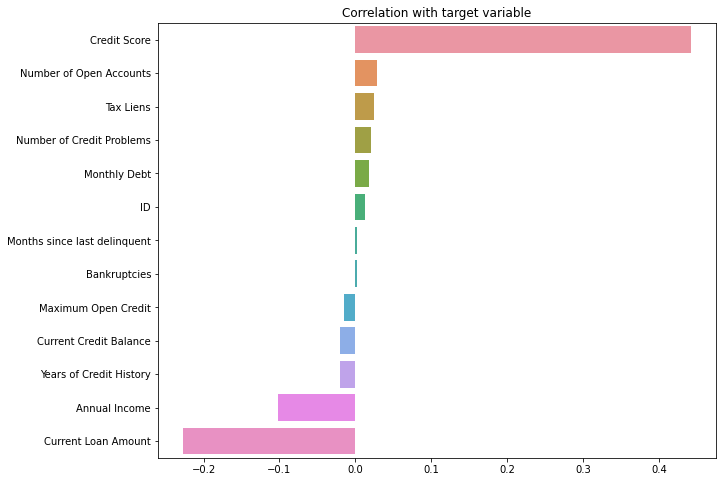

In [402]:
corr_with_target = df_train[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

# Дальше пока не успел.....

In [163]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [164]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [167]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [182]:
pd.crosstab(df_train['Tax Liens'], df_train['Credit Default'])

Credit Default,0,1
Tax Liens,,
0.0,5301,2065
1.0,59,24
2.0,15,15
3.0,5,5
4.0,3,3
5.0,1,1
6.0,2,0
7.0,1,0


In [ ]:
pd.crosstab(df_train['Tax Liens'], df_train['Credit Default'])

In [173]:
pd.crosstab(df_train['Number of Credit Problems'], df_train['Credit Default'])

Credit Default,0,1
Number of Credit Problems,,
0.0,4654,1815
1.0,641,241
2.0,60,33
3.0,21,14
4.0,3,6
5.0,3,4
6.0,4,0
7.0,1,0


In [174]:
pd.crosstab(df_train['Home Ownership'], df_train['Credit Default'])

Credit Default,0,1
Home Ownership,,
Have Mortgage,10,2
Home Mortgage,2721,916
Own Home,455,192
Rent,2201,1003


<AxesSubplot:xlabel='Months since last delinquent'>

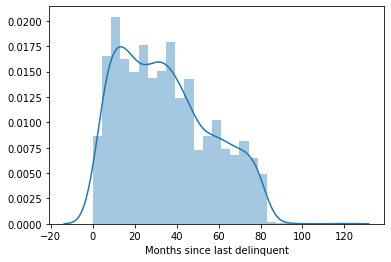

In [191]:
sns.distplot(df_train.loc[df_train['Months since last delinquent'].notnull(), 'Months since last delinquent'])

In [192]:
pd.crosstab(df_train['Bankruptcies'], df_train['Credit Default'])

Credit Default,0,1
Bankruptcies,,
0.0,4782,1878
1.0,569,217
2.0,20,11
3.0,5,2
4.0,1,1


In [193]:
pd.crosstab(df_train['Term'], df_train['Credit Default'])

Credit Default,0,1
Term,,
Long Term,1128,816
Short Term,4259,1297


In [175]:
pd.crosstab(df_train['Months since last delinquent'], df_train['Credit Default'])

Credit Default,0,1
Months since last delinquent,,
0.0,12,6
1.0,15,11
2.0,18,7
3.0,22,8
4.0,16,15
...,...,...
84.0,0,1
86.0,0,1
91.0,1,0


<AxesSubplot:xlabel='Annual Income'>

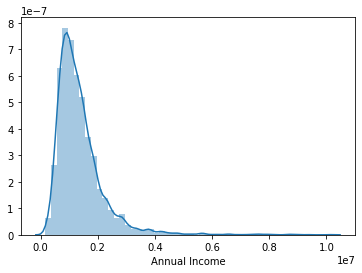

In [96]:
sns.distplot(df_train[pd.notnull(df_train['Annual Income'])]['Annual Income'])

C:\Users\mvideo\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\mvideo\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\mvideo\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\mvideo\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\mvideo\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binne

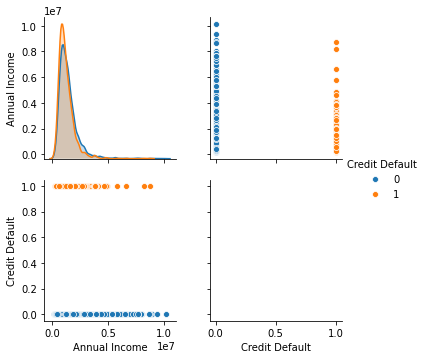

In [176]:
sns.pairplot(df_train.loc[:, ['Annual Income', 'Credit Default']], hue='Credit Default')

<AxesSubplot:xlabel='Annual Income'>

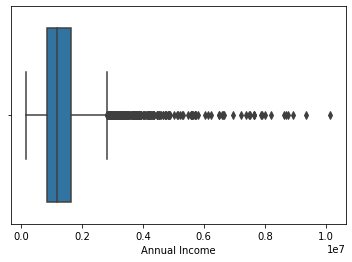

In [180]:
sns.boxplot(df_train['Annual Income'])

In [181]:
df_train['Annual Income'].describe()

count    5.943000e+03
mean     1.366392e+06
std      8.453392e+05
min      1.645970e+05
25%      8.443410e+05
50%      1.168386e+06
75%      1.640137e+06
max      1.014934e+07
Name: Annual Income, dtype: float64

In [97]:
df_defaul1=df_train[df_train['Credit Default']==1]
df_defaul0=df_train[df_train['Credit Default']==0]
sns.distplot(df_defaul1[pd.notnull(df_defaul1['Credit Score'])]['Credit Score'])


In [ ]:
sns.distplot(df_defaul0[pd.notnull(df_defaul0['Credit Score'])]['Credit Score'])

In [98]:
df_defaul0=df_train[df_train['Credit Default']==0]

<AxesSubplot:xlabel='Credit Score'>

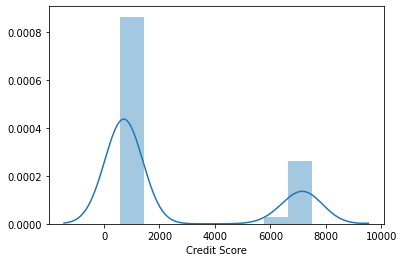

In [99]:
sns.distplot(df_defaul1[pd.notnull(df_defaul1['Credit Score'])]['Credit Score'])


In [100]:
df_defaul0['Credit Score'].std()

25.412545225110982

<AxesSubplot:xlabel='Credit Score'>

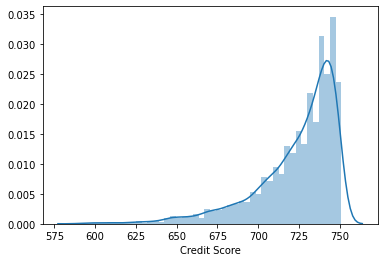

In [101]:
sns.distplot(df_defaul0[pd.notnull(df_defaul0['Credit Score'])]['Credit Score'])

C:\Users\mvideo\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\mvideo\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\mvideo\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\mvideo\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\mvideo\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binne

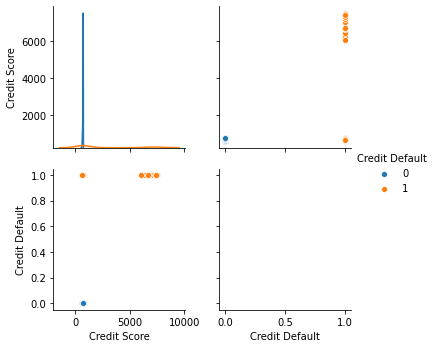

In [102]:
sns.pairplot(df_train.loc[:, ['Credit Score', 'Credit Default']], hue='Credit Default')

In [103]:
df_train.corr()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
Annual Income,1.000000,0.066245,0.188524,0.186531,0.062218,-0.015407,-0.101787,-0.066877,0.032082,0.386481,0.584819,-0.037832,-0.101375
Tax Liens,0.066245,1.000000,-0.005360,0.009109,-0.002410,0.595339,0.052446,0.057360,-0.007835,-0.010195,0.027211,0.010581,0.024368
Number of Open Accounts,0.188524,-0.005360,1.000000,0.144819,0.023897,-0.017813,-0.032740,-0.019130,0.001346,0.267325,0.413904,0.016095,0.028884
Years of Credit History,0.186531,0.009109,0.144819,1.000000,0.029247,0.071259,-0.015375,0.085699,0.010623,0.217856,0.191978,-0.015683,-0.020567
Maximum Open Credit,0.062218,-0.002410,0.023897,0.029247,1.000000,-0.004750,-0.003849,-0.011650,-0.002334,0.088090,0.010197,-0.009136,-0.014275
Number of Credit Problems,-0.015407,0.595339,-0.017813,0.071259,-0.004750,1.000000,0.139905,0.730751,-0.008596,-0.124137,-0.042252,-0.018473,0.020088
Months since last delinquent,-0.101787,0.052446,-0.032740,-0.015375,-0.003849,0.139905,1.000000,0.162710,0.000459,-0.027198,-0.057702,-0.004395,0.002598
Bankruptcies,-0.066877,0.057360,-0.019130,0.085699,-0.011650,0.730751,0.162710,1.000000,-0.005987,-0.142849,-0.079579,-0.027488,0.001648
Current Loan Amount,0.032082,-0.007835,0.001346,0.010623,-0.002334,-0.008596,0.000459,-0.005987,1.000000,0.016672,-0.009382,-0.108552,-0.226522
Current Credit Balance,0.386481,-0.010195,0.267325,0.217856,0.088090,-0.124137,-0.027198,-0.142849,0.016672,1.000000,0.504964,-0.006159,-0.019522


### Обработка пропусков в данных

In [104]:
len(df_train) - df_train.count()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [105]:
df_train.loc[df_train['Annual Income'].isnull(), 'Annual Income'] = df_train['Annual Income'].median()

In [106]:
df_train.loc[df_train['Years in current job'].isnull(), 'Years in current job'] = 'unempoyed'

In [107]:
df_train=df_train.drop(['Months since last delinquent'], axis=1)

In [108]:
df_train.loc[df_train['Bankruptcies'].isnull(), 'Bankruptcies'] = random.choices([0.0,1.0,2.0,3.0,4.0],weights=[0.8, 0.1, 0.005, 0.001, 0.0005])[0]

In [109]:
df_train.loc[df_train['Credit Score']<755, 'Credit Score'] = 0

In [110]:
df_train.loc[df_train['Credit Score']>=755, 'Credit Score'] = 1

In [111]:
df_train.loc[df_train['Credit Score'].isnull(), 'Credit Score'] = 2

In [112]:
pd.crosstab(df_train['Credit Score'], df_train['Credit Default'])

Credit Default,0,1
Credit Score,,
0.0,4359,1184
1.0,0,400
2.0,1028,529


In [113]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Home Ownership             7500 non-null   object 
 1   Annual Income              7500 non-null   float64
 2   Years in current job       7500 non-null   object 
 3   Tax Liens                  7500 non-null   float64
 4   Number of Open Accounts    7500 non-null   float64
 5   Years of Credit History    7500 non-null   float64
 6   Maximum Open Credit        7500 non-null   float64
 7   Number of Credit Problems  7500 non-null   float64
 8   Bankruptcies               7500 non-null   float64
 9   Purpose                    7500 non-null   object 
 10  Term                       7500 non-null   object 
 11  Current Loan Amount        7500 non-null   float64
 12  Current Credit Balance     7500 non-null   float64
 13  Monthly Debt               7500 non-null   float

In [114]:
df_train['Bankruptcies'].value_counts()

0.0    6674
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

### Приведение типов

In [115]:
for colname in ['Tax Liens','Home Ownership', 'Years in current job', 'Purpose', 'Term', 'Number of Credit Problems', 'Bankruptcies', 'Credit Score']:
    df_train[colname] = df_train[colname].astype(str)

In [116]:
df_train.dtypes

Home Ownership                object
Annual Income                float64
Years in current job          object
Tax Liens                     object
Number of Open Accounts      float64
Years of Credit History      float64
Maximum Open Credit          float64
Number of Credit Problems     object
Bankruptcies                  object
Purpose                       object
Term                          object
Current Loan Amount          float64
Current Credit Balance       float64
Monthly Debt                 float64
Credit Score                  object
Credit Default                 int64
dtype: object

In [117]:
for cat_colname in df_train.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years     2332
2 years        705
3 years        620
< 1 year       563
5 years        516
1 year         504
4 years        469
6 years        426
7 years        396
unemployed     371
8 years        339
9 years        259
Name: Years in current job, dtype: int64
****************************************************************************************************

Tax Liens

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
5.0       2
6.0       2
7.0       1
Name: Tax Liens, dtype: int64
****************************************************************************************************

Number of Credit Problems

0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name

### Выделить целевую переменную в отделный DF

In [118]:
df_train_target = df_train.loc[:, ['Credit Default']]


In [119]:
df_train=df_train.drop(['Credit Default'], axis=1)

In [134]:
df_train_target.to_csv(PREP_DATASET_TRARGET_PATH, index=False, encoding='utf-8')

### Построение новых признаков

In [120]:
#df_train['ID'] = df.index.tolist()

In [121]:
for cat_colname in df_train.select_dtypes(include='object').columns[1:]:
    df_train = pd.concat([df_train, pd.get_dummies(df_train[cat_colname], prefix=cat_colname)], axis=1)

In [122]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 68 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Home Ownership                   7500 non-null   object 
 1   Annual Income                    7500 non-null   float64
 2   Years in current job             7500 non-null   object 
 3   Tax Liens                        7500 non-null   object 
 4   Number of Open Accounts          7500 non-null   float64
 5   Years of Credit History          7500 non-null   float64
 6   Maximum Open Credit              7500 non-null   float64
 7   Number of Credit Problems        7500 non-null   object 
 8   Bankruptcies                     7500 non-null   object 
 9   Purpose                          7500 non-null   object 
 10  Term                             7500 non-null   object 
 11  Current Loan Amount              7500 non-null   float64
 12  Current Credit Balan

In [123]:
categorical_columns = df_train.columns[df_train.dtypes == 'object']

In [124]:
categorical_columns

Index(['Home Ownership', 'Years in current job', 'Tax Liens',
       'Number of Credit Problems', 'Bankruptcies', 'Purpose', 'Term',
       'Credit Score'],
      dtype='object')

In [125]:
df_train = df_train.drop(categorical_columns, axis=1)

In [126]:
df_train

,Annual Income,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Current Loan Amount,Current Credit Balance,Monthly Debt,Years in current job_1 year,Years in current job_10+ years,Years in current job_2 years,...,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,Term_Long Term,Term_Short Term,Credit Score_0.0,Credit Score_1.0,Credit Score_2.0
0,482087.0,11.0,26.3,685960.0,99999999.0,47386.0,7914.0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1,1025487.0,15.0,15.3,1181730.0,264968.0,394972.0,18373.0,0,1,0,...,0,0,0,0,0,1,0,1,0,0
2,751412.0,11.0,35.0,1182434.0,99999999.0,308389.0,13651.0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
3,805068.0,8.0,22.5,147400.0,121396.0,95855.0,11338.0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
4,776264.0,13.0,13.6,385836.0,125840.0,93309.0,7180.0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,402192.0,3.0,8.5,107866.0,129360.0,73492.0,1900.0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
7496,1533984.0,10.0,26.5,686312.0,444048.0,456399.0,12783.0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
7497,1878910.0,12.0,32.1,1778920.0,99999999.0,477812.0,12479.0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
7498,1168386.0,21.0,26.5,1141250.0,615274.0,476064.0,37118.0,0,0,0,...,0,0,0,0,0,0,1,0,0,1


In [128]:
df_train.to_csv(PREP_DATASET_PATH, index=False, encoding='utf-8')

### Рабиение тренировочного дата-сета на обучающую и контрольную выборки

In [7]:
df_train_prep = pd.read_csv(PREP_DATASET_PATH) 
df_train_target_prep=pd.read_csv(PREP_DATASET_TRARGET_PATH) 

In [8]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(df_train_prep, df_train_target_prep, test_size=0.25)

In [89]:
def quality (y_train, y_test):
    print ('precision ',precision_score (y_train, y_test) )
    print('recall ',recall_score (y_train, y_test) )
    print ('f1_score ', f1_score(y_train, y_test) )

### Случайный лес

In [48]:
from sklearn.ensemble import RandomForestClassifier

In [53]:
clf1 = RandomForestClassifier(n_estimators=100)


In [54]:
clf1 = clf1.fit(X_train, np.ravel(y_train))

In [55]:
y_result1=clf1.predict(X_test)

In [90]:
quality(y_result1, y_test)

precision  0.31529850746268656
recall  0.7412280701754386
f1_score  0.4424083769633507


### Градиентный бустинг

In [138]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

clf2 = GradientBoostingClassifier (learning_rate=0.1,max_depth=10)
clf2.fit(X_train, np.ravel(y_train))


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=10,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [139]:

y_result2=clf2.predict(X_test)


In [140]:
quality(y_result2, y_test)

precision  0.3562992125984252
recall  0.6557971014492754
f1_score  0.461734693877551


### Voting Classifier

In [92]:
#стандартизация признаков

In [94]:
scaler = StandardScaler()

In [95]:
scaler.fit(df_train_prep)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [97]:
X=scaler.transform(df_train_prep)

In [98]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, df_train_target_prep, test_size=0.25)

In [116]:

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

clf1 = LogisticRegression(random_state=1, max_iter=1000)
clf2 = RandomForestClassifier(n_estimators=100, random_state=1)
clf3 = GaussianNB()
clf4 = GradientBoostingClassifier (learning_rate=0.1,max_depth=50)

eclf = VotingClassifier(estimators=[('lr', clf1),
                                    ('rf', clf2), 
                                    ('gnb', clf3), 
                                    ('gb',clf4)], 
                                      voting='hard')

eclf = eclf.fit(X_train, np.ravel(y_train))

C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [117]:
y_result3=eclf.predict(X_test)

In [118]:
quality(y_result3, y_test)

precision  0.33070866141732286
recall  0.8038277511961722
f1_score  0.4686192468619247


### LogisticRegression

In [108]:
clf1 = LogisticRegression(random_state=1, max_iter=1000)

In [109]:
clf1.fit(X_train, np.ravel(y_train))

C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [111]:
y_result4=clf1.predict(X_test)

In [112]:
quality(y_result4, y_test)

precision  0.28346456692913385
recall  0.8
f1_score  0.4186046511627907


### Cross-Validation + Gradient Boosting

In [153]:
X=df_train_prep

In [154]:
y=df_train_target_prep

In [155]:
clf=GradientBoostingClassifier (loss='exponential', learning_rate=0.1,max_depth=50)
from sklearn.model_selection import ShuffleSplit
n_samples = X.shape[0]
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
cross_val_score(clf, X, np.ravel(y), cv=cv, scoring='f1')


array([0.4769688 , 0.46024465, 0.48744939, 0.46117274, 0.44607843])

In [156]:
clf

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='exponential', max_depth=50,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)